In [9]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [14]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

pointCount = 100
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-1, 1e-2, 1e-3]
iterations = [1000, 2000, 4000]

In [15]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)
yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        xInt = generateData.samplePoints(pointCount)
        
        # compute loss and backpropagate
        gradInt = network.computeValueFunctionDerivative(xInt)
        equation = lqr.computeHamiltonJacobiEquation(xInt, gradInt)
        loss = torch.mean( equation**2 )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

0 / 7000 (0 / 1000), lr:1.0e-01, loss:1.52e-01
100 / 7000 (100 / 1000), lr:1.0e-01, loss:7.13e-03
200 / 7000 (200 / 1000), lr:1.0e-01, loss:5.94e-04
300 / 7000 (300 / 1000), lr:1.0e-01, loss:3.15e-04
400 / 7000 (400 / 1000), lr:1.0e-01, loss:2.83e-04
500 / 7000 (500 / 1000), lr:1.0e-01, loss:2.43e-04
600 / 7000 (600 / 1000), lr:1.0e-01, loss:2.38e-04
700 / 7000 (700 / 1000), lr:1.0e-01, loss:2.88e-04
800 / 7000 (800 / 1000), lr:1.0e-01, loss:7.38e-04
900 / 7000 (900 / 1000), lr:1.0e-01, loss:1.61e-04
1000 / 7000 (0 / 2000), lr:1.0e-02, loss:1.43e-04
1100 / 7000 (100 / 2000), lr:1.0e-02, loss:1.09e-04
1200 / 7000 (200 / 2000), lr:1.0e-02, loss:1.45e-04
1300 / 7000 (300 / 2000), lr:1.0e-02, loss:1.51e-04
1400 / 7000 (400 / 2000), lr:1.0e-02, loss:1.23e-04
1500 / 7000 (500 / 2000), lr:1.0e-02, loss:9.59e-05
1600 / 7000 (600 / 2000), lr:1.0e-02, loss:1.23e-04
1700 / 7000 (700 / 2000), lr:1.0e-02, loss:1.89e-04
1800 / 7000 (800 / 2000), lr:1.0e-02, loss:1.22e-04
1900 / 7000 (900 / 2000), lr

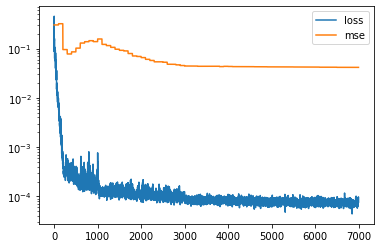

In [16]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

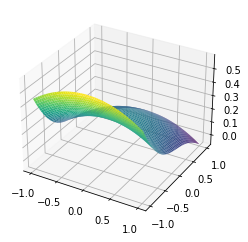

In [17]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');